In [1]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
%matplotlib qt 

# Dynamique de déplacement de voitures dans un système autoroutier

[FR]

Nous avons choisi d’étudier les dynamiques de déplacement des voitures sur différents types de routes afin de pouvoir comprendre quelle type de route est le plus efficace et comment pourrait-on faire pour fluidifier les trafics routiers.

Nous avons donc créer plusieurs types de routes sur lesquelles nous avons simuler différents groupes de voitures qui agissent entres elles et qui ont une certaine probabilité d’avoir un accident.

On s’attendait au debut à constater que si une route allant d’un point A à un point B etait large et utilisé et plus il etait nécessaire de la prendre pour arriver le plus rapidement à déstination.

Or nous avons pu observé qu'en rentrant des probabilités accidentelles propre aux différents types de routes, il était au final largement plus intéressant de prendre une route à une voie plus longue qu'une route à 2 voie plus courte.

Notre conclusion est assimilable à l'exemple de Pigou (1920)

[EN]

We chose to study the dynamics of moving cars on different types of roads in order to understand which type of road is the most efficient and how could we make traffic flows smoother.

So we created several types of roads on which we simulate different groups of cars that act between them and have a certain probability of having an accident.

It was initially expected that if a route from point A to point B was wide and used, it was necessary to take it to reach the destination as quickly as possible.

However, we observed that, in entering accidental probabilities specific to the different types of roads, it was in fact much more interesting to take a longer one-lane road than a shorter two-lane road.

Our conclusion is comparable to the example of Pigou (1920)     

# 1. Modèle de route à une voie

### Comment modéliser un tel phénomène ?

Considérons un ensemble de **voitures**. Par soucis de simplicité nous faisons abstraction des variations de vitesses et considérons que toutes les voitures se déplacent soit à une vitesse constante, soit à une vitesse nulle si elles sont à l'arrêt. Une voiture à une probabilité $p$ de tomber en panne pendant un temps $t$. Afin de pouvoir obtenir une simulation visualisable, nous choisirons une probabilité assez élevée (0.5% pour chaque tour pour chaque voiture).
Chaque individu du groupe de voiture est modélisé par un son numero d'arrivé sur la route ce qui nous permet de "tracer" cette dernière sur la route.

Commençons par créer notre classe voiture.
On définit sa position sur la route et sur la voie, le temps qu'elle reste sur cette route, sa probabilité d'avoir un accident, son etat (si accidenté ou non) ainsi que son numero d'arrivé sur la route.
On définit ensuite une fonction qui va permettre aux voitures de rouler.
Si elles sont dans un etat non accidenté, elles peuvent avancer et ont une probabilité $p$ de tomber en panne, tandis que si une voiture est accidentée, elle ne peut pas re-tomber en passe et ne peut pas avancer.

In [52]:
class voiture:
    
    def __init__(self, proba,name):
        self.x = 0
        self.y = 1
        self.temp = 0
        self.proba = proba
        self.etat = 0 #si different de 0 alors accident et traffic à l'arret
        self.j = name

    def roule(self):
        if self.etat == 0:
            self.x += 1
            if self.proba == 0 :
                self.accident = 0
            else :
                self.accident = randint(1, self.proba)
                #Il y a une autre façon de génerer une probabilité que l'on
                #dans les simulation qui suivront.
            if self.accident == 1 and self.x>0:
                self.etat = 8
        else :
            self.etat += -1
    

Créons maintenant notre classe voiture.
On définit la liste de voitures qui va la traverser, le débit de voiture sur la route, la grille matricielle sur laquelle on representa les voitures avec différentes températures afin de pouvoir obtenir une visulation graphique de l'avancé à l'aide de np.zeros, la distance de la route, la probabilité qu'ont les voitures de tomber en panne ainsi que le nombre des voitures qui ont finit de traverser.

In [53]:
class route:
    
    def __init__(self, debit, distance, proba):
        self.voitures = [voiture(proba,0)]
        self.debit = debit
        #fin de l'ajout
        
        self.grid = np.zeros(shape=(distance,3))
        self.distance = distance
        self.state_route = self.grid
        self.proba = proba
        
        #truc pour le temps
        self.inc = 0
        self.voitures_passe = 0

    def update_route(self):
        
        ancienne_route = self.state_route.copy()
        
        self.state_route = np.zeros((self.distance, 3))
        
        for item in self.voitures:
            if item.x>=0 and item.x<(self.distance-1) and ancienne_route[item.x+1][item.y] != 0:
                item.etat = 1
                item.temp += 1
                self.state_route[item.x][item.y] = 6
                item.roule()
            else :
                item.roule()
                if item.x >= 0 and item.x < self.distance:
                    item.temp += 1
                    self.state_route[item.x][item.y] = 10
                    if item.etat != 0 :
                        self.state_route[item.x][item.y] = 6
        
        #generation de nouvelles voitures
        self.inc += 1
        if self.inc%self.debit == 0 and self.state_route[1][0] == 0 and self.state_route[1][1] == 0 and self.state_route[1][2] == 0:
            self.voitures.append(voiture(self.proba,self.inc))
            
    def bilan(self) :
        nb = 0
        temps = 0
        for i in self.voitures :
            if i.x >= self.distance :
                nb += 1
                temps += i.temp
        print("les voitures ont mis {} tours en moyenne pour traverser la route".format(temps/nb))
           

On test notre route en lui atribuant une distance de 2, une route de longueur 15 et une probabilité de tomber en panne de 1%.

les voitures ont mis 29 tours en moyenne pour traverser la route


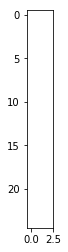

In [54]:
images = []
road = route(4,25,100)
fig = plt.figure()
for j in range(300):
    road.update_route()
    road.state_route

    image = plt.imshow(road.state_route, vmin=0, vmax=13, cmap="hot")
    images.append([image])
animation= anim.ArtistAnimation(fig, images)
animation.save("./Video_num1.mp4")
road.bilan()

# 2. Modèle de route à une voie avec une sortie

Dans cette seconde partie nous utiliserons une route simulaire à celle simulée précedemment qui aura en plus une sortie de voie placée sur la route.

On rajoute à la classe voiture une valeur immun qui fera en sorte que, si la voiture a pris la sortie, cette dernière ne pourra pas avoir d'accident.

In [55]:
class voiture:
    
    def __init__(self, proba,name):
        self.x = 0
        self.y = 1
        self.temp = 0
        self.proba = proba
        self.etat = 0 #si different de 0 alors accident et stop traffic
        self.j = name

    def roule(self):
        if self.etat == 0:
            self.x += 1
            if self.proba == 0 :
                self.accident = 0
            else :
                self.accident = randint(1, self.proba)
                #Il y a une autre façon de génerer une probabilité que l'on
                #dans les simulation qui suivront.
            if self.accident == 1 and self.x>0:
                #si la voiture est acidentée elle ne sera pas accidentée.
                self.etat = 8
        else :
            self.etat += -1
    

On initialisera maintenant la route en lui atribuant la valeur de la sortie souhatée, ainsi, si la une voiture est embouteillée à cet emplacement, elle aura la possibilité de prendre la sortie.

In [56]:
class route:
    
    def __init__(self, debit, distance, proba, sortie):
        self.voitures = [voiture(proba,0)]
        self.debit = debit
        #fin de l'ajout
        self.sortie = sortie
        self.grid = np.zeros(shape=(distance,5))
        self.distance = distance
        self.state_route = self.grid
        self.proba = proba
        
        #truc pour le temps
        self.inc = 0
        self.voitures_passe = 0

    def update_route(self):
        
        ancienne_route = self.state_route.copy()
        
        self.state_route = np.zeros((self.distance, 5))
        
        for item in self.voitures:
            if item.x>=0 and item.x<(self.distance-1) and ancienne_route[item.x+1][item.y] != 0:
                if item.x == self.sortie :
                    #la voiture peut prendre la sortie, on la rend immunisé pour les accidents en 
                    #affectant une valeur à proba. On change aussi ses coordonnée et on la place sur
                    #la route.
                    item.proba = 0
                    item.y = 3
                    self.state_route[item.x+1][item.y] = 10
                else : 
                    item.etat = 1
                    self.state_route[item.x][item.y] = 6
                item.roule()
                item.temp += 1
            else :
                item.roule()
                if item.x >= 0 and item.x < self.distance:
                    item.temp += 1
                    self.state_route[item.x][item.y] = 10
                    if item.etat != 0 :
                        self.state_route[item.x][item.y] = 6
        
        #generation de nouvelles voitures
        self.inc += 1
        if self.inc%self.debit == 0 and self.state_route[1][0] == 0 and self.state_route[1][1] == 0 and self.state_route[1][2] == 0:
            self.voitures.append(voiture(self.proba,self.inc))
            
    def bilan(self) :
        nb = 0
        temps = 0
        for i in self.voitures :
            if i.x >= self.distance :
                nb += 1
                temps += i.temp
        print("les voitures ont mis {} tours en moyenne pour traverser la route".format(temps/nb))
           

les voitures ont mis 28 tours en moyenne pour traverser la route


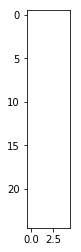

In [57]:
images = []
road = route(4,25,100,7)
fig = plt.figure()
for j in range(300):
    road.update_route()
    road.state_route

    image = plt.imshow(road.state_route, vmin=0, vmax=13, cmap="hot")
    images.append([image])
animation= anim.ArtistAnimation(fig, images)
animation.save("./Video_num2.mp4")
road.bilan()

# 3. Modèle de route à deux voies sans changement de voie.

Dans cette partie nous simulerons 2 routes simulaires à celles simulées précedemment.

( possibilitée de passer directement à la partie suivante )

La classe voiture est identique à celle de base excepté qu'elle prend maintenant un paramètre en plus, la couleur qui la définit, afin de différencier les voitures des deux voies.

In [58]:
class voiture:
    
    def __init__(self, proba, name, couleur):
        self.x = 0
        self.temps = 0
        self.proba = proba
        self.etat = 0 #si different de 0 alors accident et stop traffic
        self.j = name
        self.couleur = couleur
        self.accident = 0
        self.temp = 0

    #la fonction qui fait rouler les voitures
    def roule(self):
        #sert à connaitre le temps mis par une voiture pour traverser la route
        if self.etat == 0: # si la voiture n'est pas accidentée
            self.x = self.x + 1
            #seconde facon d'utiliser les probabilitées
            if (np.random.uniform(0,1) < self.proba):
                self.etat = 8
        else :
            self.etat += -1

Il est donc nécessaire de générer deux listes distinctes pour générer deux groupes de voiture indépendants que l'on fera rouler de la même fçon que précedemment.

In [59]:
class route:
    
    def __init__(self, debit, distance, proba):
        #1er groupe de voitures :
        self.voitures1 = [voiture(proba=proba, name=0, couleur=9)]
        #2eme groupe de voitures :
        self.voitures2 = [voiture(proba=proba, name=0, couleur=13)]
        self.debit = debit
        
        self.grid = np.zeros(shape=(distance,5))
        self.distance = distance
        self.state_route = np.zeros((self.distance, 5))
        self.proba = proba
    
        self.inc = 0
        self.voitures_passe = 0

    def update_route(self):
        
        ancienne_route = self.state_route.copy()
    
        self.state_route = ancienne_route
        self.state_route[:, 1] = 0
                        
        for item in self.voitures1: #voie gauche
            ### Si il y a blocage devant et que je peux passer sur l'autre voie
            if item.x >= 0 and item.x < (self.distance -1) \
                           and ancienne_route[item.x + 1][1] != 0:
                item.etat = 2
                self.state_route[item.x][1] = 5 # couleur arret 
                item.temp += 1
                item.roule()

            else :
                item.roule()
                if item.x >= 0 and item.x < self.distance:
                    item.temp += 1
                    self.state_route[item.x][1] = item.couleur#couleur gauche
                    if item.etat != 0 : # si accident sur le .roule()
                        self.state_route[item.x][1] = 5 #couleur arret
                        
            #print(' emplacement1 : {} voit num: '.format(item.x), item.j)
        self.state_route[:, 3] = 0
        
        for item in self.voitures2:
            if item.x>=0 and item.x<(self.distance-1) \
                         and self.state_route[item.x + 1][3] != 0:
                item.etat = 2
                self.state_route[item.x][3] = 5 # couleur arret 
                item.temp += 1
                item.roule()

            else :
                item.roule()
                if item.x >= 0 and item.x < self.distance:
                    item.temp += 1
                    self.state_route[item.x][3] = item.couleur
                    if item.etat != 0 :
                        self.state_route[item.x][3] = 5
                 
            #print([item.x for item in self.voitures])
        
        #generation de nouvelles voitures
        self.inc += 1
        #On génere ici la première liste de voitures
        
        if self.inc%self.debit == 0 and self.state_route[0][1] == 0 and self.state_route[1][1] == 0:
            self.voitures1.append(voiture(self.proba,self.inc,9))
            
        #On génere ici la seconde liste de voitures
        
        if self.inc%self.debit == 0 and self.state_route[0][3] == 0 and self.state_route[1][3] == 0:
            self.voitures2.append(voiture(self.proba,self.inc,13))
        
    def bilan(self) :
        nb = 0
        temps = 0
        for i in self.voitures1 :
            if i.x >= self.distance :
                nb += 1
                temps += i.temp
        for i in self.voitures2 :
            if i.x >= self.distance :
                nb += 1
                temps += i.temp
        print("les voitures ont mis {} tours en moyenne pour traverser la route".format(temps/nb))


les voitures ont mis 29 tours en moyenne pour traverser la route


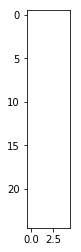

In [60]:
images = []
road = route(4,25, 0.01)
fig = plt.figure()
for j in range(300):
    road.update_route()
    road.state_route

    image = plt.imshow(road.state_route, vmin=0, vmax=13, cmap="hot")
    images.append([image])
animation= anim.ArtistAnimation(fig, images)
animation.save("./Video_num3.mp4")
road.bilan()

# 4. Modèle de route à deux voies avec changement de voie.

Dans cette dernière partie, nous simulerons donc de la même façon que précedemment 2 routes distinctes. Ici en revanche nous ferons intéragir les 2 groupes de voitures entre eux. Nous ferons en sorte que lorsqu'une voiture est bloquée sur la route elle passe sur l'autre route si elle en a la possibilitée.

On utilise la même classe voiture utilisée précedemment.

In [67]:
class voiture:
    
    def __init__(self, proba, name, couleur):
        self.x = 0
        self.proba = proba
        self.etat = 0 #si different de 0 alors accident et stop traffic
        self.j = name
        self.couleur = couleur
        self.accident = 0
        self.temp = 0 #LE COMPTEEEEUR

    #la fonction qui fait rouler les voitures
    def roule(self):
        #sert à connaitre le temps mis par une voiture pour traverser la route
        if self.etat == 0: # si la voiture n'est pas accidentée
            self.x = self.x + 1
            
            if int(np.random.uniform(0,1) < self.proba):
                self.etat = 8
        else :
            self.etat += -1

Nous allons donc comme précedemment génerer deux listes indépendentes. Afin de faire passer une voiture d'une voie à l'autre il sera necessaire de regarder si la voiture à la place pour se joindre à l'autre liste, de l'ajouter à l'autre liste au bon emplacement ainsi que de la supprimer de la liste initiale.

In [68]:
class route:
    
    def __init__(self, debit, distance, proba):
        self.voitures1 = [voiture(proba=proba, name=0, couleur=9)]
        self.voitures2 = [voiture(proba=proba, name=0, couleur=13)]
        self.debit = debit
        
        self.grid = np.zeros(shape=(distance,5))
        self.distance = distance
        self.state_route = np.zeros((self.distance, 5))
        self.proba = proba
    
        self.inc = 0
        self.voitures_passe = 0

    def update_route(self):
        
        ancienne_route = self.state_route.copy()
    
        self.state_route = ancienne_route
        self.state_route[:, 1] = 0

        for idx, item in enumerate(self.voitures1): #voie gauche
            ### Si il y a blocage devant et que je peux passer sur l'autre voie
            if item.x >= 0 and item.x < (self.distance -1) \
                           and ancienne_route[item.x + 1][1] != 0:
                    
                item.temp += 1
                
                if ancienne_route[item.x - 1][3] == 0 \
                   and ancienne_route[item.x][3] == 0 \
                   and ancienne_route[item.x + 1][3] == 0 \
                   and item.x != 1:

                    self.state_route[item.x][3] = item.couleur #couleur gauche
                    item.etat = 0
                    
                    #On ajoute la voiture dans l'autre liste et on la supprime de la liste initiale.
                    for i in range(len(self.voitures2)) :
                    
                        if self.voitures2[i].x < item.x :
                            self.voitures2.insert(i, item)
                            self.voitures1 = [x for i, x in enumerate(self.voitures1) if i != idx]
                            print("voiture de la voie 1 supprimee a la position: {}".format(item.x))
                            break
                else:
                    item.etat = 1
                    self.state_route[item.x][1] = 5 # couleur arret
                    

            else :
                item.roule()
                if item.x >= 0 and item.x < self.distance:
                    item.temp += 1
                    self.state_route[item.x][1] = item.couleur#couleur gauche
                    if item.etat != 0 : # si accident sur le .roule()
                        self.state_route[item.x][1] = 5 #couleur arret
                
            #print(' emplacement1 : {} voit num: '.format(item.x), item.j)
        self.state_route[:, 3] = 0
        
        for idx, item in enumerate(self.voitures2):
            if item.x>=0 and item.x<(self.distance-1) \
                         and self.state_route[item.x + 1][3] != 0:
                    
                item.temp += 1
                
                if self.state_route[item.x -1][1] == 0 and self.state_route[item.x][1] == 0 \
                         and self.state_route[item.x + 1][1] == 0 \
                         and item.x != 1:
                    self.state_route[item.x][1] = item.couleur
                    item.etat = 0

                    for i in range(len(self.voitures1)):
                        if self.voitures1[i].x < item.x :
                            self.voitures1.insert(i, item)
                            print("voiture de la voie 2 supprimee a la position: {}".format(item.x))
                            self.voitures2 = [x for i, x in enumerate(self.voitures2) if i != idx]
                            break

                else:
                    item.etat = 1
                    self.state_route[item.x][3] = 5 #arret
                

            else :
                item.roule()
                if item.x >= 0 and item.x < self.distance:
                    item.temp += 1
                    self.state_route[item.x][3] = item.couleur
                    if item.etat != 0 :
                        self.state_route[item.x][3] = 5
                 
            #print([item.x for item in self.voitures])
        
        #generation de nouvelles voitures
        self.inc += 1
        if self.inc%self.debit == 0 and self.state_route[0][1] == 0 and self.state_route[1][1] == 0:
            self.voitures1.append(voiture(self.proba,self.inc,9))
        if self.inc%self.debit == 0 and self.state_route[0][3] == 0 and self.state_route[1][3] == 0:
            self.voitures2.append(voiture(self.proba,self.inc,13))
        
        #compteur de voitures passées
        #for i in self.voitures1:
            #if i.x == self.distance :
                #print( "ping ! la voiture ",i.j," a traversee l'autoroute ! elle a mis",i.temps)
                #del i
    def bilan(self) :
        nb = 0
        temps = 0
        for i in self.voitures1 :
            if i.x >= self.distance :
                nb += 1
                temps += i.temp
        for i in self.voitures2 :
            if i.x >= self.distance :
                nb += 1
                temps += i.temp
        print("les voitures ont mis {} tours en moyenne pour traverser la route".format(temps/nb))
        

voiture de la voie 1 supprimee a la position: 22
voiture de la voie 1 supprimee a la position: 22
voiture de la voie 1 supprimee a la position: 7
voiture de la voie 1 supprimee a la position: 8
voiture de la voie 1 supprimee a la position: 8
voiture de la voie 1 supprimee a la position: 3
voiture de la voie 1 supprimee a la position: 9
voiture de la voie 1 supprimee a la position: 9
voiture de la voie 1 supprimee a la position: 5
voiture de la voie 1 supprimee a la position: 5
voiture de la voie 1 supprimee a la position: 5
voiture de la voie 2 supprimee a la position: 10
voiture de la voie 2 supprimee a la position: 10
voiture de la voie 1 supprimee a la position: 19
voiture de la voie 2 supprimee a la position: 16
voiture de la voie 1 supprimee a la position: 20
voiture de la voie 1 supprimee a la position: 20
voiture de la voie 2 supprimee a la position: 4
voiture de la voie 1 supprimee a la position: 8
voiture de la voie 1 supprimee a la position: 8
voiture de la voie 2 supprimee a

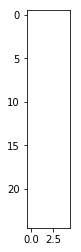

In [73]:
images = []
road = route(4,25, 0.01)
fig = plt.figure()
for j in range(300):
    road.update_route()
    road.state_route

    image = plt.imshow(road.state_route, vmin=0, vmax=13, cmap="hot")
    images.append([image])
animation= anim.ArtistAnimation(fig, images)
animation.save("./Video_num4.mp4")
road.bilan()

# 4. Expérimentations et observations.

Nous cherchons donc à vérifier si il est plus judicieux de prendre une route large très empruntée ou bien une route à une voie plus longue moins empruntée. 

Afin de modéliser cela nous pouvons nous servir de statistiques obtenues sur un article d'un des sites officiel du gouvernement : https://www.onisr.securite-routiere.interieur.gouv.fr/contenus/etudes-et-recherches/environnement-et-infrastructures/reseaux-ruraux/hierarchisation-des-reseaux-routiers-departementaux-et-accidentalite

Cet article nous informe que le réseau structurant (routes à plus de 2 voies) représente 1/3 du linéaire de réseau départemental mais porte les 2/3 du trafic et des accidents.

Cela signifie que 2/3 du linéaire de réseau routier est non-structurant (1 voie) et porte 1/3 du trafic et des accidents. Ainsi 1/3 du linéaire de réseau routier est non-structurant (1 voie) et porte 1/6 du trafic et des accidents, soit 4 fois moins qu'un résau structurant.

Nous avons donc modéliser la route à une voie avec une probabilitée accidentelle de 1% et avons modéliser la route à 2 voies avec une probabilité accidentelle de 4%.

Nous avons éffectués ces modélisations 10 fois sur 500 itérations.

Nous avons obtenus que sur une route a une voie de longueur 75 et une probabilité d'avoir un accident de 1%, les personnes mettent en moyenne 90 iterations a parcourir la route, tandis que pour une route a 2 voies d'une longueur inférieur (70) et une probabilité d'avoir un accident de 4%, les voitures mettent en moyenne 145 itérations a parcourir la route.

On peut donc conclure que prendre une route juste parcequ'elle est large n'est pas forcément judicieux.

Ainsi notre hypothèse de base, qui est une idée très répendu, était fausse.

On peut assimiler nos résultats au prix de l'anarchie et plus précisément à la remarque de pigou qui dit que un système de communication régulé de manière « centralisée », imposant des comportements à certains individus, peut circuler beaucoup mieux qu’un système dans lequel chacun peut choisir son comportement comme bon lui semble. L’« optimum social » est (parfois) bien meilleur que l’« optimum libéral ». Pas vraiment une surprise. L’union fait la force...

Un exemple assez connu à eu lieu en 1990 à l’occasion de la « journée de la Terre ». La municipalité de New York décida de fermer la 42-ème rue à la circulation. Cette rue étant l’une des plus animées de Manhattan, on pensait que cette fermeture ne manquerait pas de ralentir la circulation et de provoquer des embouteillages supplémentaires. C’est le contraire qui se passa : le fait de fermer la 42-ème rue rendit la circulation plus fluide !


# Bibliographie

https://en.wikipedia.org/wiki/Microscopic_traffic_flow_model

https://en.wikipedia.org/wiki/Biham%E2%80%93Middleton%E2%80%93Levine_traffic_model

https://en.wikipedia.org/wiki/Nagel%E2%80%93Schreckenberg_model

https://images.math.cnrs.fr/Le-prix-de-l-anarchie 

https://fr.wikipedia.org/wiki/Prix_de_l%27anarchie 

http://victorknoop.eu/research/papers/chapter_vanwee.pdf

https://ascelibrary.org/doi/abs/10.1061/(ASCE)0733-947X(1997)123:4(261)

https://www.sciencedirect.com/science/article/pii/019126079090047A